In [1]:
import torch
import torch.nn as nn
import pandas as pd
from project.dataset import Dataset, VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform
from project.utils import collatev2
import winsound
from project.utils import compute_statistics
from project.evaluation import isa_rpn_metric, isa_vit_metric, Tracker

d:\Programming Files\Python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.21 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations


In [2]:
vit_tk = Tracker()

### Monitoring and CUDA Setup


In [3]:
import logging
from datetime import datetime as dtt
import os

path = 'logs'
os.makedirs(path, exist_ok=True)
os.makedirs('history', exist_ok=True)
rn = dtt.now()
dte = rn.strftime('%b_%d_%Y_%H%M%S')

logger = logging.getLogger('kess')
fh = logging.FileHandler(f'logs/rpn_vit_{dte}.log')
formatter = logging.Formatter(
    '%(asctime)s - %(levelname)s - %(message)s'
)

logger.setLevel(logging.DEBUG)
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)

logger.addHandler(fh)

dte

'Nov_22_2024_085143'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
vit_tk.date = rn
vit_tk.logfile = f'rpn_vit_{dte}.log'
vit_tk.device = device

### Config for RPN and ViT Fitter


In [6]:
from project.model import ISAVIT, Feeder

In [7]:
image_size = 300
patch_size = 32

In [8]:
vit_config = {
    'model': ISAVIT(
        d_model=512,
        patch_size=patch_size,
        dim_ff=1600,
        global_context=False,
    ).to(device),
    'optimizer': torch.optim.Adam,
    'device': device,
    'epochs': 50,
    'loss': nn.BCEWithLogitsLoss(),
    'lr': 0.0001
}

d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [9]:
vit_tk.model = 'ViT'
vit_tk.model_hyperparams = vit_config['model'].config
vit_tk.optimizer = f"{vit_config['optimizer']}"
vit_tk.epochs = vit_config['epochs']
vit_tk.loss = f"{vit_config['loss']}"
vit_tk.lr = vit_config['lr']

### Dataset Loading


In [10]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

In [11]:
data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
data

,mri,masks,stripped,target,has_microbleed_case,has_microbleed_slice,cohort,max_value,slices
0,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,8,1,1,1,928.405273,35
1,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,9,1,1,1,928.405273,35
2,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,11,1,1,1,928.405273,35
3,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,12,1,1,1,928.405273,35
4,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,15,1,1,1,928.405273,35
...,...,...,...,...,...,...,...,...,...
359,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,241.000000,36
360,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,26,1,1,3,241.000000,36
361,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,24,1,1,3,448.000000,39
362,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,d:\Github\Thesis and ML Project\Dataset\VALDO_...,25,1,1,3,448.000000,39


In [12]:
vit_tk.only_cmb_slices = True

In [13]:
def make_feedset(
        data,
        target_shape=(300, 300),
        rpn_mode=True,
        logger=None
    ):
    s = f'Creating feedset\n'
    paths = data.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'
    global_min, global_max = compute_statistics(paths)
    
    feedset_transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )
    feedset = VALDODataset(
    cases=data.stripped,
    masks=data.masks,
    target=data.target,
    transform=feedset_transform
    )
    print(s)
    return feedset

In [14]:
feedset = make_feedset(
    data=data,
    rpn_mode=True,
    target_shape=(300, 300)
)

Creating feedset
Total Unique MRI Samples in data_train: 50
GLOBAL MIN & MAX (0.0, 87519.8515625)



### Preprocessing and Train-Test Split Function


In [15]:
from sklearn.model_selection import train_test_split

def make_loaders(data,
                 cohort,
                 test_size=0.2,
                 random_state=12,
                 target_shape=(300, 300),
                 rpn_mode=True,
                 logger=None,
                ):
    
    if cohort == 1:
        vit_tk.cohort1 = True
    if cohort == 2:
        vit_tk.cohort2 = True
    if cohort == 3:
        vit_tk.cohort3 = True

    vit_tk.test_size = test_size
    vit_tk.target_shape = target_shape
    data = data[data.cohort == cohort]
    
    s = f'Creating loaders for Cohort {cohort}\n'

    data_train, data_test = train_test_split(
        data,
        test_size=test_size,
        random_state=random_state
    )

    s += f'TRAIN & TEST: {data_train.shape, data_test.shape}\n'

    paths = data_train.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )

    train_set = VALDODataset(
        cases=data_train.stripped.tolist(),
        masks=data_train.masks.tolist(),
        target=data_train.target.tolist(),
        transform=transform
    )
    val_set = VALDODataset(
        cases=data_test.stripped.tolist(),
        masks=data_test.masks.tolist(),
        target=data_test.target.tolist(),
        transform=transform
    )

    if logger != None:
        logger.info(s)
    else:
        print(s)
    
    return train_set, val_set

In [16]:
from project import Fitter
from project.preprocessing import get_transform

In [17]:
resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

In [18]:
import torch

In [19]:
feeder = Feeder(resize)

### ViT Fitter


In [20]:
from project import Fitter

class ViTFitter(Fitter):
    
    def fit(self, train_loader, val_loader):
        train_history = []
        val_history = []
        train_metric_history = []
        val_metric_history = []
        for epoch in range(self.epochs):
            self.log(f'EPOCH {epoch} ==============================')
            train_loss, train_metric = self.train_one_epoch(train_loader)
            val_loss, val_metric = self.validation(val_loader)
            train_history.append(train_loss)
            val_history.append(val_loss)
            train_metric_history.append(train_metric)
            val_metric_history.append(val_metric)
        return train_history, val_history, train_metric_history, val_metric_history

    def train_one_epoch(self, train_loader):
        self.model.train()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        counter = 0
        for batch in train_loader:
            Y = []
            T = []
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float().to(self.device)
                masks = masks.float().to(self.device)

                regions = feedset.locate_case_by_mri(case)
                bboxes = regions[1].view(regions[1].shape[0], -1)
                bbox = bboxes[target].int().tolist()
                
                x = feeder(slices, bbox, 32)
                t = feeder(masks, bbox, 32)

                x = x.flatten(2).float().to(self.device)
                t = t.flatten(2).float().to(self.device)
                # self.log(f'XT SHAPES: {x.shape}, {t.shape}')
                
                y = self.model(x, target)
                
                # print('Prediction:', (y.sigmoid() >= 0.5).int().unique())
                # print('Truth:', (t[target] >= 0).int().unique())

                dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))

                evaluation_metric['dice_score'].append(dice_score)
                evaluation_metric['precision_score'].append(precision_score)
                evaluation_metric['recall_score'].append(recall_score)
                evaluation_metric['f1_score'].append(f1_score)
                evaluation_metric['fpr'].append(fpr)
                # self.log(f'EVAL METS: {dice_score, precision_score, recall_score, f1_score, fpr}')

                Y.append(y)
                T.append(t[target])
            
            losses = self.loss(torch.stack(Y), torch.stack(T))
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()
            counter += 1
            self.log(f'Batch:\t{counter}/{len(train_loader)}')
            self.log(f'Batch samples:\t{len(batch)}')
            self.log(f'Current error:\t{losses}\n')
            
            loss_history.append(losses.detach().cpu().numpy())
        
        self.log(f'\nTraining Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric
    
    def validation(self, val_loader):
        self.model.eval()
        loss_history = []
        evaluation_metric = {
            'dice_score': [], 
            'precision_score': [], 
            'recall_score': [], 
            'f1_score': [],
            'fpr': []
        }
        with torch.inference_mode():
            for batch in val_loader:
                Y = []
                T = []
                for slices, masks, target, case in batch:
                    slices = slices.squeeze(1).float().to(self.device)
                    masks = masks.float().to(self.device)
                    regions = feedset.locate_case_by_mri(case)
                    bboxes = regions[1].view(regions[1].shape[0], -1)
                    bbox = bboxes[target].int().tolist()
                
                    x = feeder(slices, bbox, 32)
                    t = feeder(masks, bbox, 32)
                    x = x.flatten(2).float().to(self.device)
                    t = t.flatten(2).float().to(self.device)
                    y = self.model(x, target)

                    dice_score, precision_score, recall_score, f1_score, fpr = isa_vit_metric((y.sigmoid().squeeze().detach().cpu().numpy() >= 0.5), (t[target].squeeze().detach().cpu().numpy() > 0))
                    evaluation_metric['dice_score'].append(dice_score)
                    evaluation_metric['precision_score'].append(precision_score)
                    evaluation_metric['recall_score'].append(recall_score)
                    evaluation_metric['f1_score'].append(f1_score)
                    evaluation_metric['fpr'].append(fpr)
                    Y.append(y)
                    T.append(t[target])
                
                losses = self.loss(torch.stack(Y), torch.stack(T))
                loss_history.append(losses.cpu().numpy())
        
        self.log(f'\nValidations Evaluation Metric:')
        self.log(f"Avg Dice: {sum(evaluation_metric['dice_score']) / len(evaluation_metric['dice_score'])}")
        self.log(f"Avg Precision: {sum(evaluation_metric['precision_score']) / len(evaluation_metric['precision_score'])}")
        self.log(f"Avg Recall: {sum(evaluation_metric['recall_score']) / len(evaluation_metric['recall_score'])}")
        self.log(f"Avg F1: {sum(evaluation_metric['f1_score']) / len(evaluation_metric['f1_score'])}")
        self.log(f"Avg FPR: {sum(evaluation_metric['fpr']) / len(evaluation_metric['fpr'])}\n")
        return loss_history, evaluation_metric

### Train-Test Split


In [21]:
vit_t1, vit_v1 = make_loaders(
    data=data,
    cohort=1,
    rpn_mode=False
)

vit_t3, vit_v3 = make_loaders(
    data=data,
    cohort=3,
    rpn_mode=False
)

Creating loaders for Cohort 1
TRAIN & TEST: ((36, 9), (9, 9))
Total Unique MRI Samples in data_train: 8
GLOBAL MIN & MAX (0.0, 1417.92822265625)

Creating loaders for Cohort 3
TRAIN & TEST: ((37, 9), (10, 9))
Total Unique MRI Samples in data_train: 26
GLOBAL MIN & MAX (0.0, 573.0)



In [22]:
from torch.utils.data import ConcatDataset

vit_train_set = ConcatDataset([vit_t1, vit_t3])
vit_test_set = ConcatDataset([vit_v1, vit_v3])

print(f'ViT Train Set Size: {vit_train_set}')
print(f'ViT Test Set Size: {vit_test_set}')

ViT Train Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000017A84A00290>
ViT Test Set Size: <torch.utils.data.dataset.ConcatDataset object at 0x0000017A849EAA90>


In [23]:
batchs = 20
vit_tk.batch_size = batchs

vit_test_dataloader = DataLoader(
    vit_test_set,
    shuffle=True,
    batch_size=batchs,
    collate_fn=collatev2
)

### K-Fold Cross Validation


In [24]:
from torch.utils.data import Subset
from sklearn.model_selection import KFold

In [25]:
kf = KFold(n_splits=5, shuffle=True, random_state=45)
kf

KFold(n_splits=5, random_state=45, shuffle=True)

In [26]:
from project.model import Feeder, GCRPN
from project.preprocessing import NiftiToTensorTransform, get_transform

In [27]:
vit_test_dice = []
vit_test_precision = []
vit_test_recall = []
vit_test_f1 = []
vit_test_fpr = []

In [28]:
rpn_fold_metrics = []
vit_fold_metrics = []


fold_dir = f'./fold/{dte}'
os.makedirs(fold_dir, exist_ok=True)

for i, (train_index, val_index) in enumerate(kf.split(vit_train_set)):
    print(f'Fold {i + 1}/{5}')

    os.makedirs(f'{fold_dir}/fold_{i+1}', exist_ok=True)

    # ViT
    
    vit_config['model'] = ISAVIT(**vit_tk.model_hyperparams).to(device)
    
    vit_fitter = ViTFitter(vit_config, logger=logger)
    
    train_subset = Subset(vit_train_set, train_index)
    val_subset = Subset(vit_train_set, val_index)

    vit_tk.batch_size = 2
    
    train_subset_dl = DataLoader(
        train_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    val_subset_dl = DataLoader(
        val_subset,
        shuffle=True,
        batch_size=vit_tk.batch_size,
        collate_fn=collatev2
    )
    
    vit_thist, vit_vhist, vit_tmhist, vit_vmhist = vit_fitter.fit(train_subset_dl, val_subset_dl)
    
    vit_fold_metrics.append({
        'fold': i + 1,
        'training_history': vit_thist,
        'validation_history': vit_vhist,
        'training_metrics': vit_tmhist,
        'validation_metrics': vit_vmhist
    })
    
    vit_h, vit_mh = vit_fitter.validation(vit_test_dataloader)
    vit_valmets = pd.DataFrame(vit_mh)
    vit_mets = vit_valmets.mean()
    
    vit_test_dice.append(vit_mets.dice_score)
    vit_test_precision.append(vit_mets.precision_score)
    vit_test_recall.append(vit_mets.recall_score)
    vit_test_f1.append(vit_mets.f1_score)
    vit_test_fpr.append(vit_mets.fpr)
    
    torch.save(vit_fitter.model.state_dict(), f'{fold_dir}/fold_{i+1}/vit_fold{i+1}.pt')

    

Fold 1/5


d:\Programming Files\Python\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:kess:EPOCH 0 ==============================
d:\Programming Files\Python\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
INFO:kess:Batch:	1/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.6935794949531555

INFO:kess:Batch:	2/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.449579656124115

INFO:kess:Batch:	3/29
INFO:kess:Batch samples:	2
INFO:kess:Curre

Fold 2/5


INFO:kess:Batch:	1/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.7725895047187805

INFO:kess:Batch:	2/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.498329758644104

INFO:kess:Batch:	3/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.31043538451194763

INFO:kess:Batch:	4/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.19450703263282776

INFO:kess:Batch:	5/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.12511157989501953

INFO:kess:Batch:	6/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.09192949533462524

INFO:kess:Batch:	7/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.0672486275434494

INFO:kess:Batch:	8/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.05418924242258072

INFO:kess:Batch:	9/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.055989209562540054

INFO:kess:Batch:	10/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.036059506237506866

INFO:kess:Batch:	11/29
INFO:kess:Batch samples:	2
I

Fold 3/5


INFO:kess:Batch:	1/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.864490270614624

INFO:kess:Batch:	2/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.5726629495620728

INFO:kess:Batch:	3/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.3599998950958252

INFO:kess:Batch:	4/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.23192191123962402

INFO:kess:Batch:	5/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.14406485855579376

INFO:kess:Batch:	6/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.10009735077619553

INFO:kess:Batch:	7/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.08052435517311096

INFO:kess:Batch:	8/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.06084394454956055

INFO:kess:Batch:	9/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.04329375550150871

INFO:kess:Batch:	10/29
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.0372886136174202

INFO:kess:Batch:	11/29
INFO:kess:Batch samples:	2
INFO

Fold 4/5


INFO:kess:Batch:	1/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.7082016468048096

INFO:kess:Batch:	2/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.4688653349876404

INFO:kess:Batch:	3/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.2972044348716736

INFO:kess:Batch:	4/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.19247229397296906

INFO:kess:Batch:	5/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.13739901781082153

INFO:kess:Batch:	6/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.09193982183933258

INFO:kess:Batch:	7/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.06611137837171555

INFO:kess:Batch:	8/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.047968894243240356

INFO:kess:Batch:	9/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.04797801002860069

INFO:kess:Batch:	10/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.036691680550575256

INFO:kess:Batch:	11/30
INFO:kess:Batch samples:	2


Fold 5/5


INFO:kess:Batch:	1/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.6733986139297485

INFO:kess:Batch:	2/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.4307253956794739

INFO:kess:Batch:	3/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.273750901222229

INFO:kess:Batch:	4/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.18293564021587372

INFO:kess:Batch:	5/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.11722864210605621

INFO:kess:Batch:	6/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.0886332169175148

INFO:kess:Batch:	7/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.06650010496377945

INFO:kess:Batch:	8/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.058177947998046875

INFO:kess:Batch:	9/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.037882931530475616

INFO:kess:Batch:	10/30
INFO:kess:Batch samples:	2
INFO:kess:Current error:	0.030645275488495827

INFO:kess:Batch:	11/30
INFO:kess:Batch samples:	2
I

In [29]:
import winsound

winsound.Beep(500, 500)
winsound.Beep(500, 500)
winsound.Beep(500, 500)

### Metrics Visualization


`rpn_fold_metrics[i]`

- represents each fold

`rpn_fold_metrics[1].keys()`

- 'fold', 'training_history', 'validation_history', 'training_metrics', 'validation_metrics'

`rpn_fold_metrics[1]['training_metrics'][i]`

- represents each epoch

`rpn_fold_metrics[1]['training_metrics'][1].keys()`

- 'iou_score', 'precision_score', 'recall_score', 'f1_score'


In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [31]:
def plot_metric_history(fold_metrics, metric, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(len(vit_fold_metrics)):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_metrics'])):
            th = np.array(fold_metrics[fold]['training_metrics'][epoch][metric]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_metrics'][epoch][metric]).mean()
            test.append(vh)
            
        sns.lineplot(x=range(1, len(train)+1), y=train, label=f'Training {metric}', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label=f'Validation {metric}', ax=ax)
    

        ax.set_title(f'{title}Training and Validation {metric}: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel(metric)
        ax.legend()
        
    plt.tight_layout()  
    plt.show()

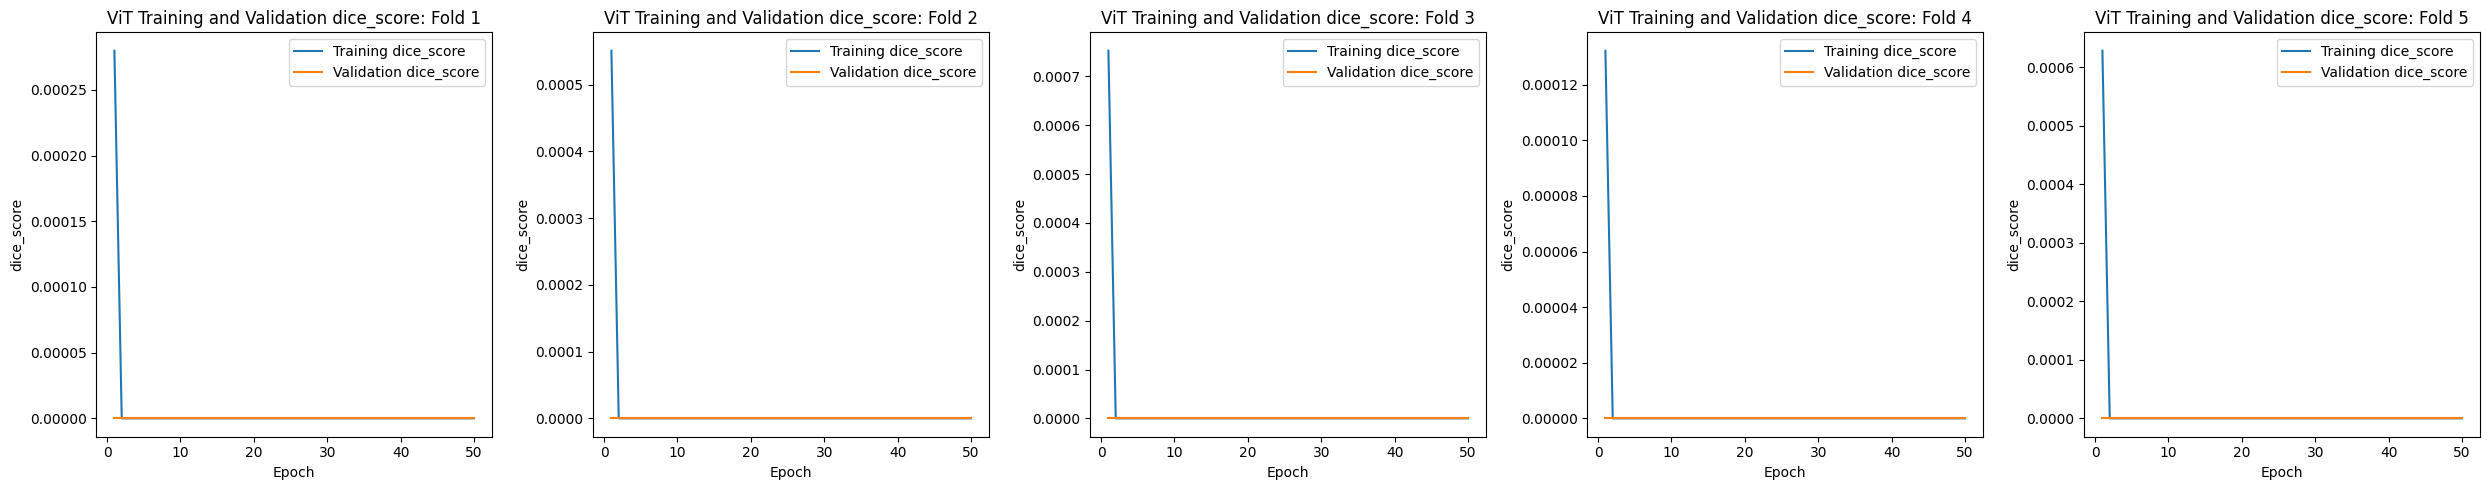

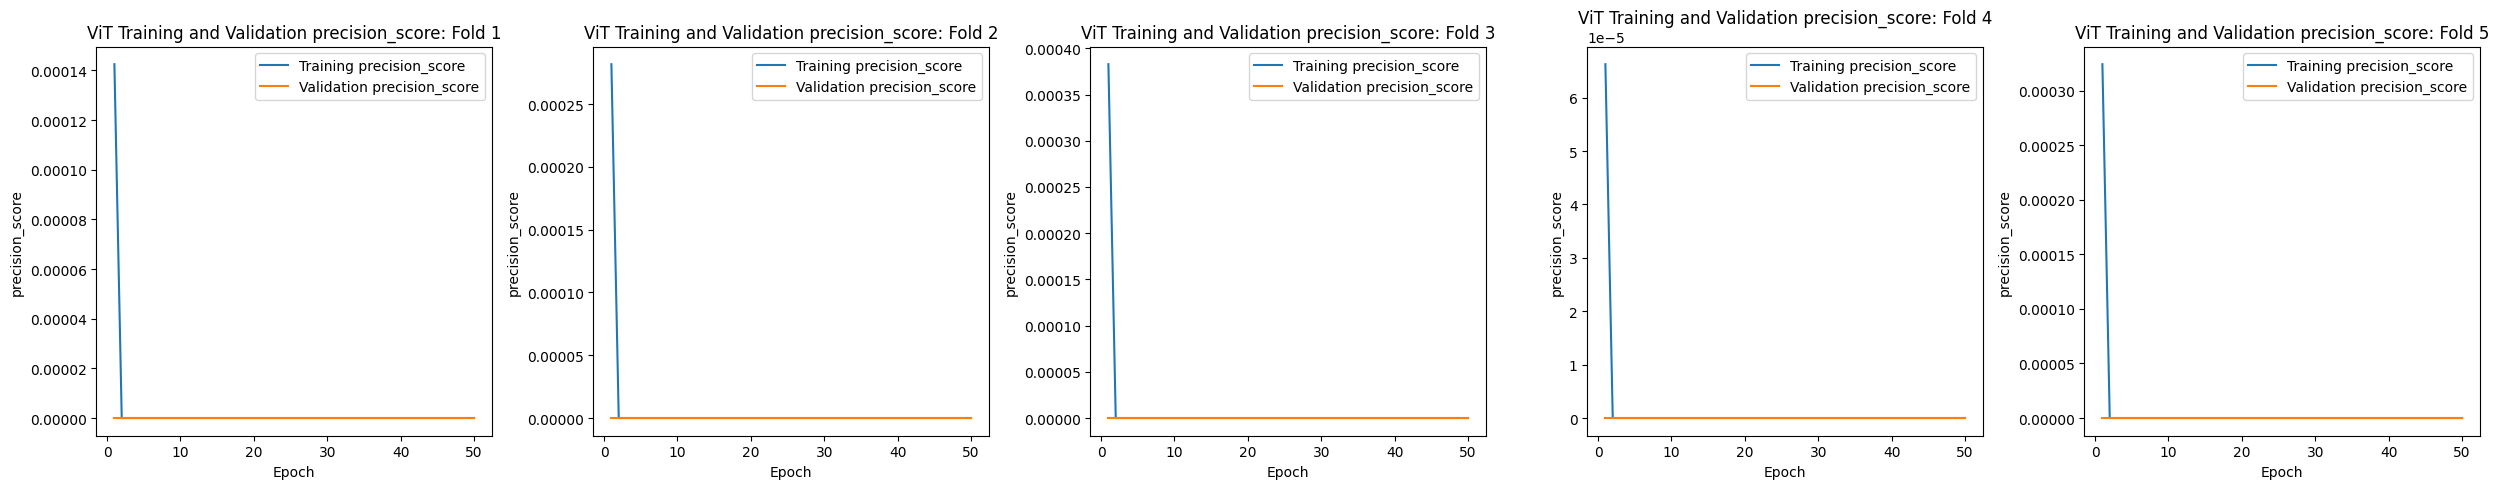

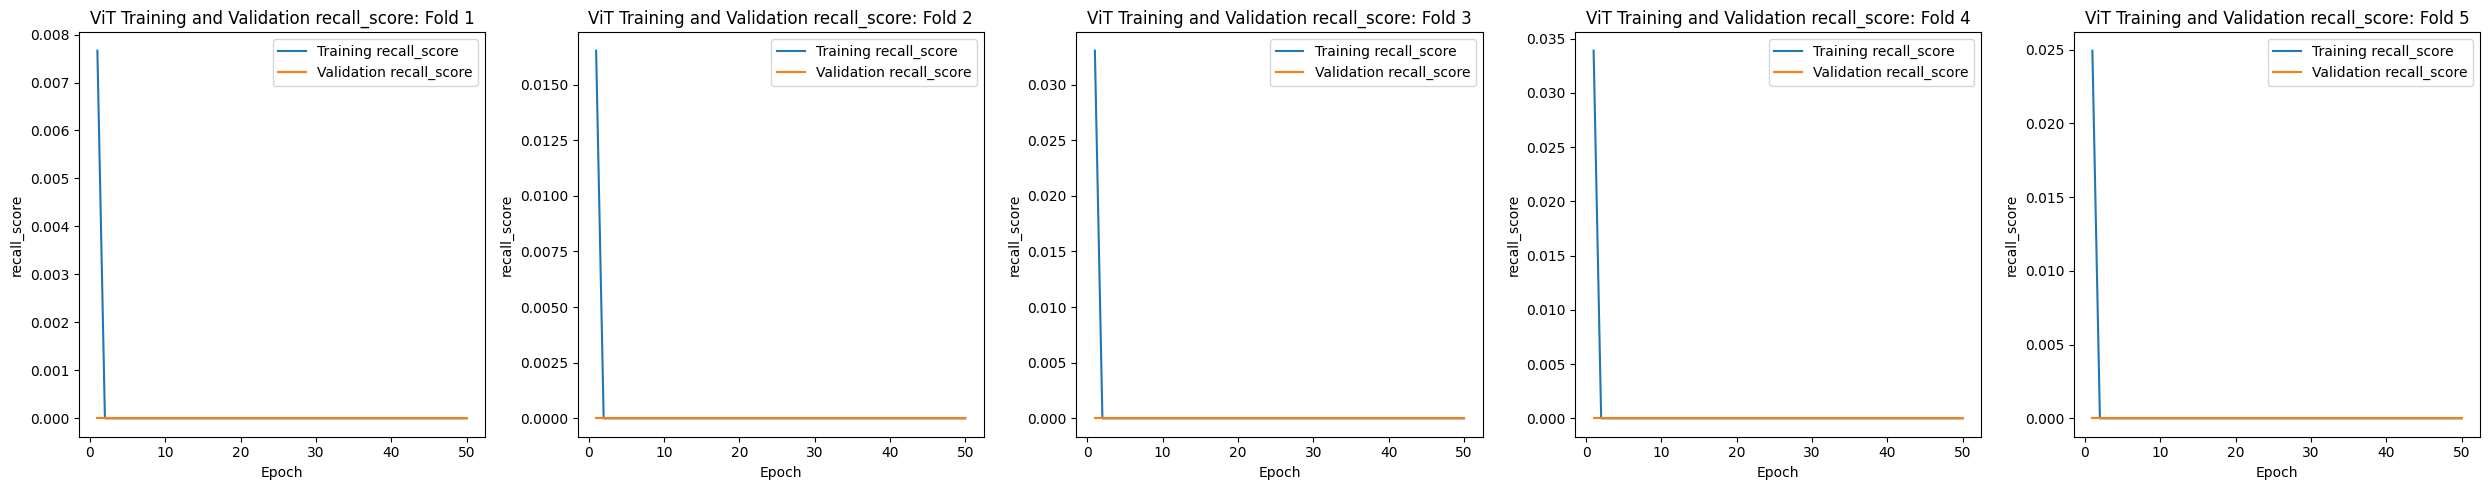

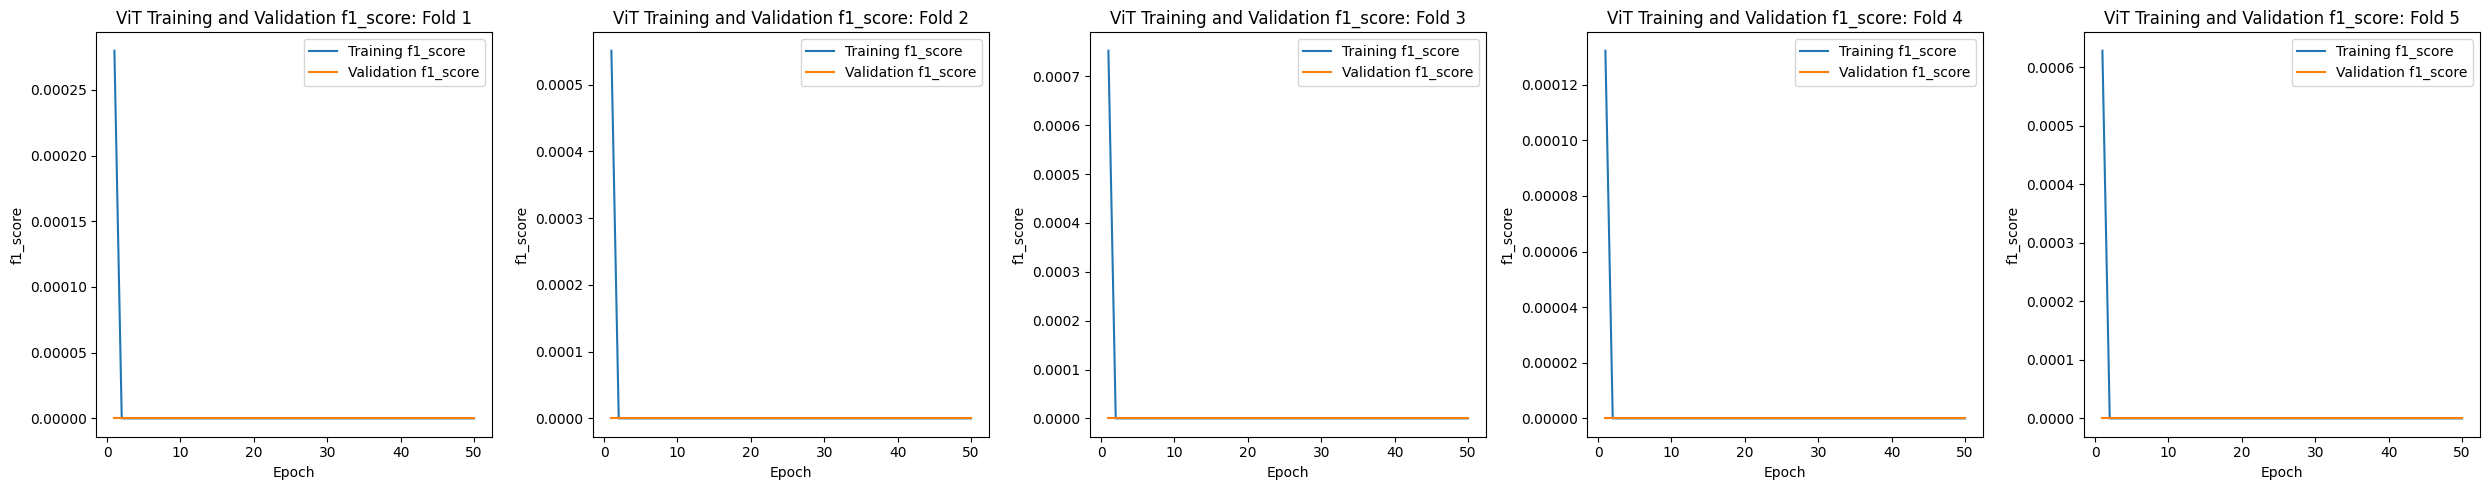

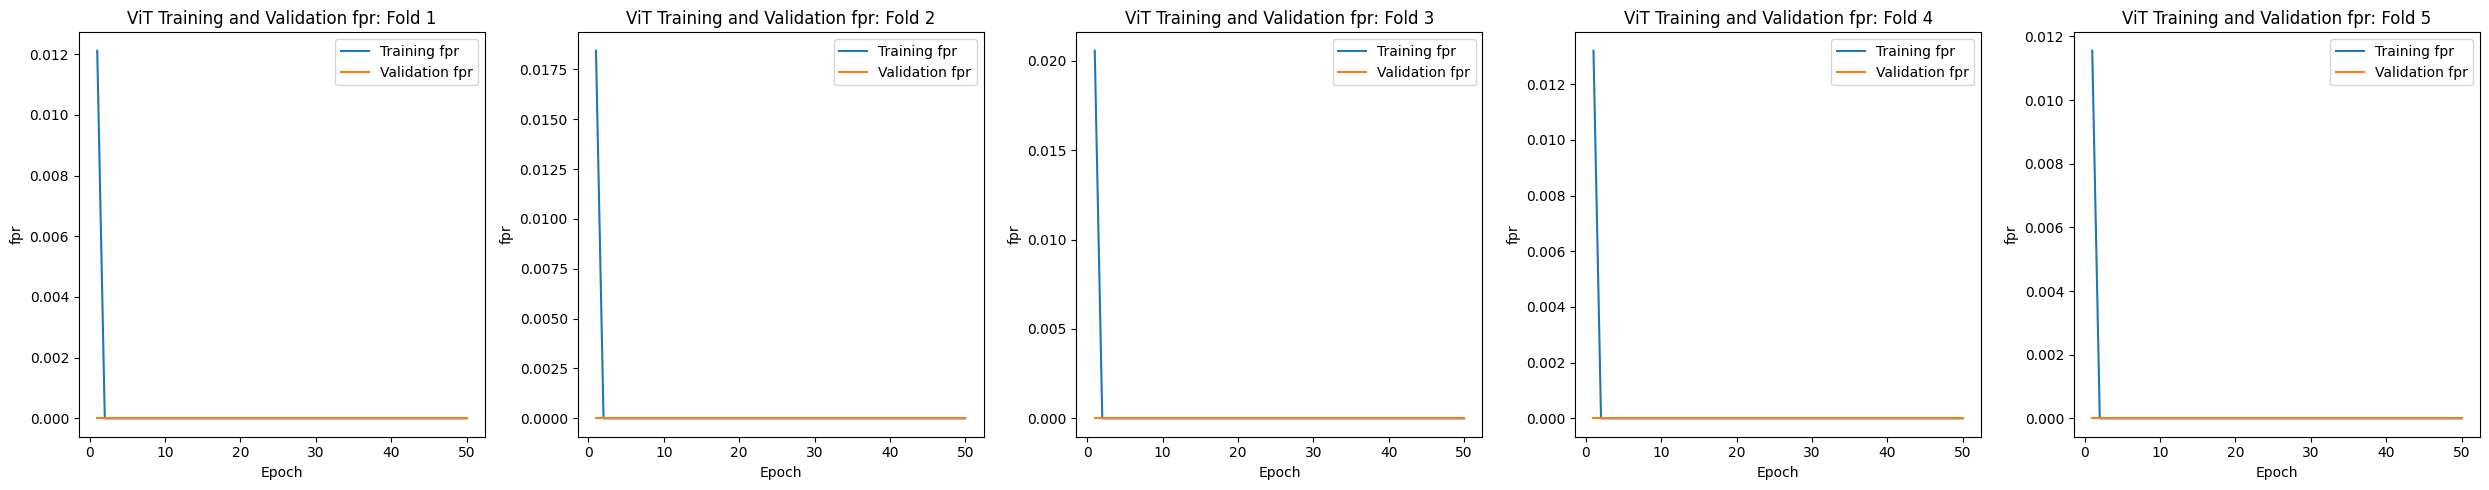

In [32]:
vit_metrics = ['dice_score', 'precision_score', 'recall_score', 'f1_score', 'fpr']

for metric in vit_metrics:
    plot_metric_history(vit_fold_metrics, metric, 'ViT ')

### Loss History Visualization


In [33]:
def plot_loss_history(fold_metrics, title=None):
    fig, axes = plt.subplots(1, 5, figsize=(25, 5))

    for fold in range(5):
        train = []
        test = []
        ax=axes[fold]
        
        for epoch in range(len(fold_metrics[fold]['training_history'])):
            th = np.array(fold_metrics[fold]['training_history'][epoch]).mean()
            train.append(th)
            vh = np.array(fold_metrics[fold]['validation_history'][epoch]).mean()
            test.append(vh)
        
        sns.lineplot(x=range(1, len(train)+1), y=train, label='Training history', ax=ax)
        sns.lineplot(x=range(1, len(test)+1), y=test, label='Validation history', ax=ax)
        
        ax.set_title(f'{title}Training and Validation History: Fold {fold+1}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
    
    plt.tight_layout()  
    plt.show()

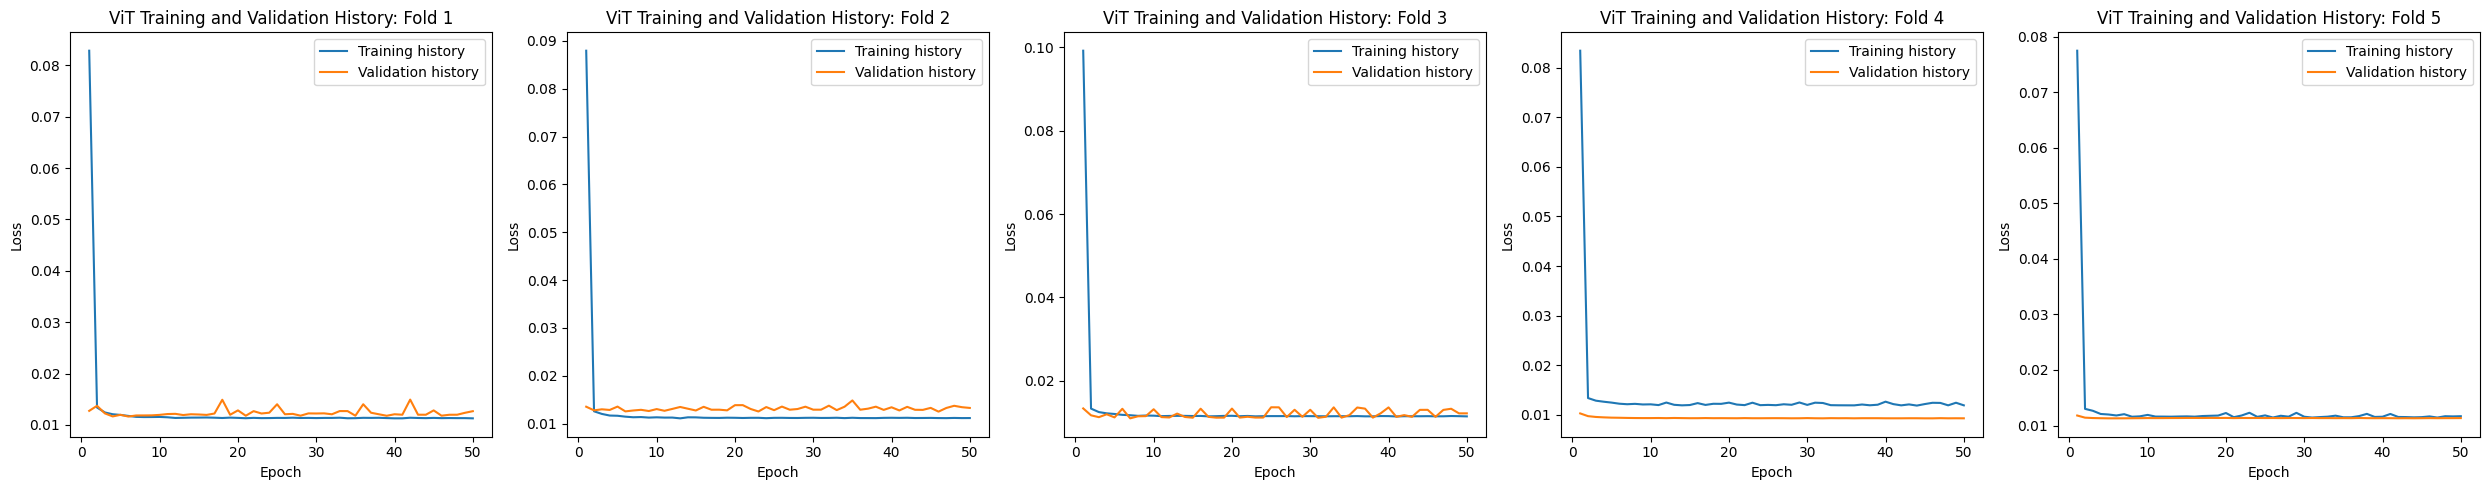

In [34]:
plot_loss_history(vit_fold_metrics, 'ViT ')

### Evaluate Test Set


#### ViT


In [35]:
df_vit_metrics = pd.DataFrame(columns=['fold', 'dice', 'precision', 'recall', 'f1', 'fpr'])
df_vit_metrics

,fold,dice,precision,recall,f1,fpr


In [36]:
df_vit_metrics['fold'] = [1, 2, 3, 4, 5]
df_vit_metrics['dice'] = vit_test_dice
df_vit_metrics['precision'] = vit_test_precision
df_vit_metrics['recall'] = vit_test_recall
df_vit_metrics['f1'] = vit_test_f1
df_vit_metrics['fpr'] = vit_test_fpr

In [37]:
vit_tk.dice = df_vit_metrics.dice
vit_tk.precision = df_vit_metrics.precision
vit_tk.recall = df_vit_metrics.recall
vit_tk.f1 = df_vit_metrics.f1
vit_tk.fpr = df_vit_metrics.fpr

In [38]:
df_vit_metrics

,fold,dice,precision,recall,f1,fpr
0,1,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0


In [39]:
# vit_iou_score = np.array(vit_test_iou).mean()
vit_dice_score = np.array(vit_test_dice).mean()
vit_precision_score = np.array(vit_test_precision).mean()
vit_recall_score = np.array(vit_test_recall).mean()
vit_f1_score = np.array(vit_test_f1).mean()
vit_fpr_score = np.array(vit_test_fpr).mean()

print('ViT Test Set Performance Metrics')
print(f'Average Dice Score: {vit_dice_score} ')
print(f'Average Precision: {vit_precision_score} ')
print(f'Average Recall: {vit_recall_score} ')
print(f'Average F1 Score: {vit_f1_score} ')
print(f'Average FPR: {vit_fpr_score} ')

ViT Test Set Performance Metrics
Average Dice Score: 0.0 
Average Precision: 0.0 
Average Recall: 0.0 
Average F1 Score: 0.0 
Average FPR: 0.0 


In [40]:
df_vit_metrics.to_csv(f'{fold_dir}/vit_metrics.csv')

In [41]:
df_vit_metrics.to_csv(f'./statistical-treatment/perfect-bbox-vanilla-vit.csv')

### Sample


#### ViT


In [42]:
vit_sample = next(enumerate(vit_test_dataloader))
vit_slices, vit_masks, vit_target, vit_case = vit_sample[1][0]

In [43]:
vit_slices = vit_slices.squeeze(1).float().to(device)
vit_masks = vit_masks.float().to(device)

In [44]:
regions = feedset.locate_case_by_mri(vit_case)
bboxes = regions[1].view(regions[1].shape[0], -1)
bbox = bboxes[vit_target].int().tolist()
                
vit_x = feeder(vit_slices, bbox, 16)
vit_t = feeder(vit_masks, bbox, 16)

<Axes: title={'center': 'Mask Slice Crop'}>

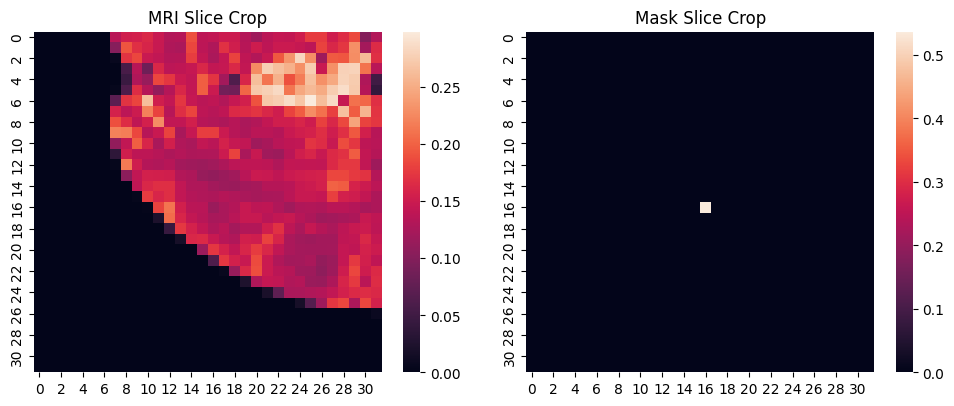

In [45]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('MRI Slice Crop')
ax2.set_title('Mask Slice Crop')
sns.heatmap(vit_x[vit_target].squeeze(), ax=ax1)
sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2)

In [46]:
vit_y = vit_fitter.model(vit_x.flatten(2).to(device), vit_target)
vit_y = vit_y.view(patch_size, patch_size)

<Axes: title={'center': 'Mask Truth'}>

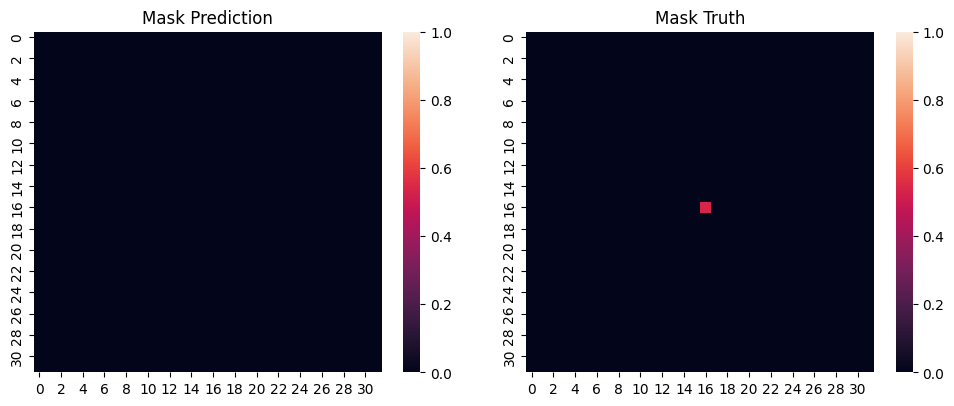

In [47]:
f, a = plt.subplots(1, 2, figsize=(10, 4))

f.tight_layout()
ax1 = a.flat[0]
ax2 = a.flat[1]
ax1.set_title('Mask Prediction')
ax2.set_title('Mask Truth')
sns.heatmap((vit_y > 0.3).detach().cpu(), ax=ax1, vmax=1)
sns.heatmap(vit_t[vit_target].squeeze(), ax=ax2, vmax=1)

# Log Progress


In [48]:
vit_tk.notes = '''
no global context
'''

In [49]:
vit_tk()

,model,loaded_weights,stage1_weights,uses_resnet,only_cmb_slices,cohort1,cohort2,cohort3,optimizer,epochs,...,recall,f1,fpr,saved_weights,saved_thist,saved_vhist,model_hyperparams,logfile,device,notes
date,,,,,,,,,,,,,,,,,,,,,
2024-11-22 08:51:43.686609,ViT,None,None,None,True,True,False,True,<class 'torch.optim.adam.Adam'>,50,...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,0 0.0 1 0.0 2 0.0 3 0.0 4 0.0 N...,None,None,None,"{'d_model': 512, 'patch_size': 32, 'dim_ff': 1...",rpn_vit_Nov_22_2024_085143.log,cuda,\nno global context\n


In [50]:
if os.path.exists('history/runs.csv'):
    print('Merging to old df')
    prev_df = pd.read_csv('history/runs.csv', index_col='date')
    merged = pd.concat([prev_df, vit_tk()])
    merged.to_csv('history/runs.csv')
else:
    print('Making new csv file')
    vit_tk().to_csv('history/runs.csv')

Merging to old df


C:\Users\JOSHUA KYLE\AppData\Local\Temp\ipykernel_22436\3886131270.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  merged = pd.concat([prev_df, vit_tk()])
